In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('hyd-monthly-rains.csv')

In [148]:
df = df.iloc[:, [0, -1]]
df

,Year,Total
0,1901,727.357028
1,1902,609.422251
2,1903,1277.937654
3,1904,569.818436
4,1905,576.005602
...,...,...
116,2017,1038.507021
117,2018,570.281508
118,2019,873.615744
119,2020,1232.341627


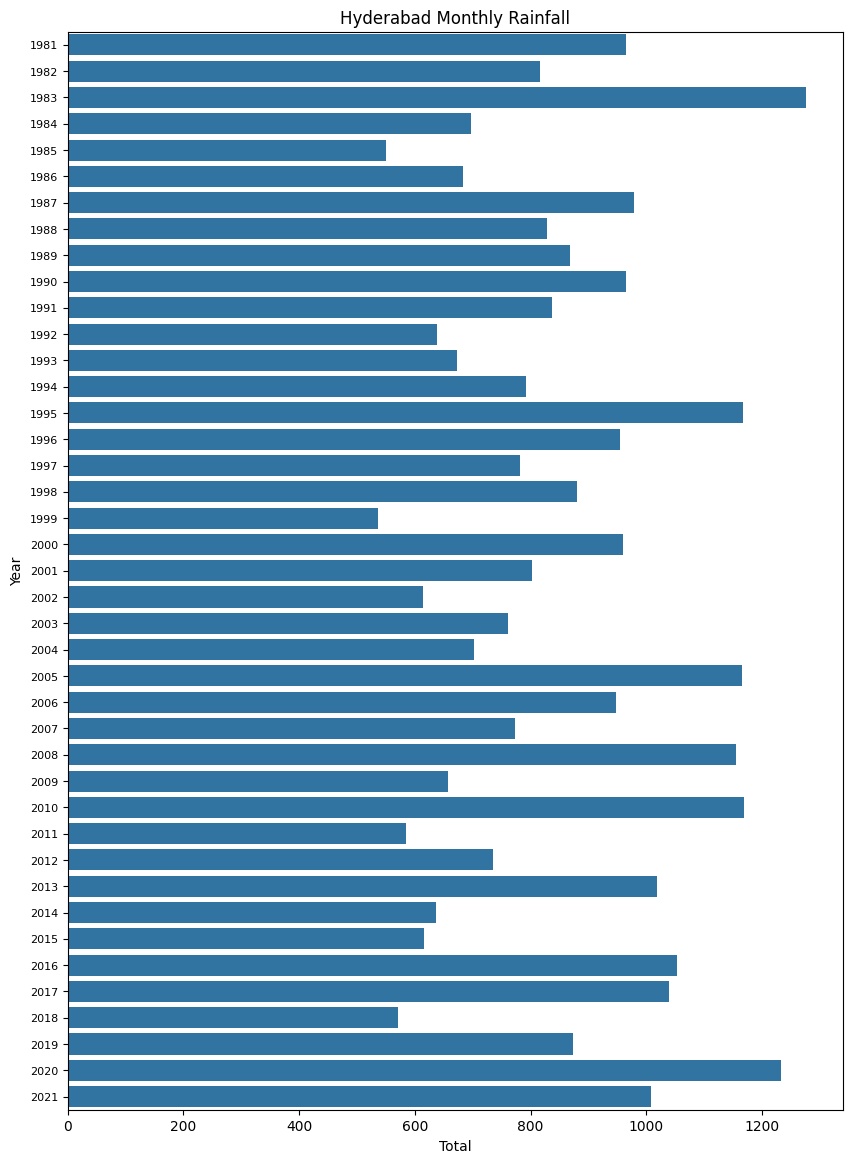

In [149]:
plt.figure(figsize=(10, 14))
df_modified = df[(df['Year'] >= 1981)]
sns.barplot(x='Total', y='Year', data=df_modified, orient='h')
plt.title('Hyderabad Monthly Rainfall')
plt.yticks(fontsize=8)
plt.show()

<Axes: xlabel='Total', ylabel='Count'>

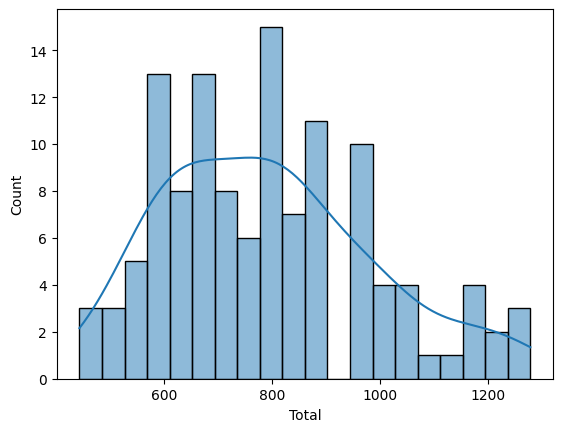

In [150]:
sns.histplot(df['Total'], bins=20, kde=True)

In [151]:
# Gaussian-Gaussian conjugacy
standard_deviation = df['Total'].std()

df_prior = df[(df['Year'] >= 1981) & (df['Year'] <= 2000)]

prior_mean = df_prior['Total'].mean()
prior_standard_deviation = df_prior['Total'].std()

df_data = df[(df['Year'] >= 2001) & (df['Year'] <= 2020)]

MovieWriter imagemagick unavailable; using Pillow instead.


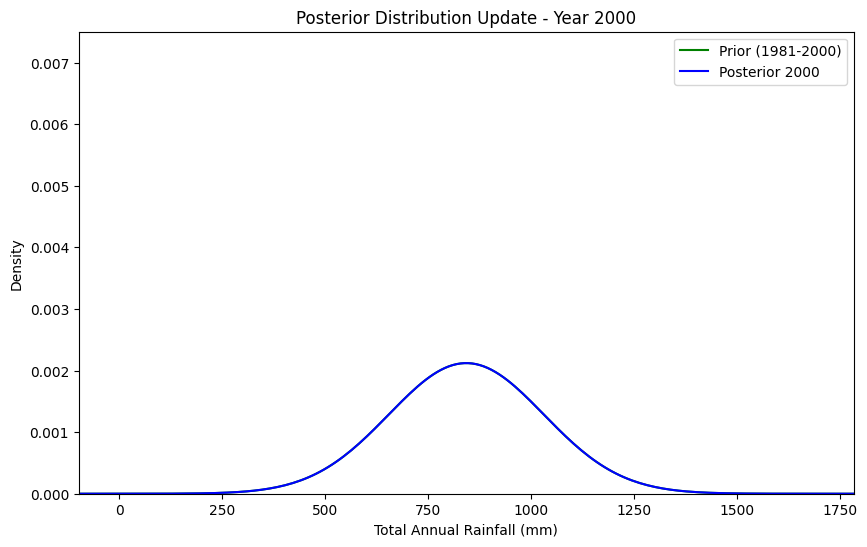

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

prior_mean = df_prior['Total'].mean()
prior_variance = df_prior['Total'].var()
data_variance = 450**2 
n_observations = len(df_data)

posterior_means = [prior_mean.round(2)]
posterior_variances = [prior_variance.round(2)]
years = [int(2000)]  

def update_posterior(prior_mean, prior_variance, data_value, data_variance):
    posterior_variance = 1 / (1 / prior_variance + 1 / data_variance)
    posterior_mean = posterior_variance * (prior_mean / prior_variance + data_value / data_variance)
    return posterior_mean, posterior_variance

for _, row in df_data.iterrows():
    year = row['Year']
    data_value = row['Total']
    posterior_mean, posterior_variance = update_posterior(
        posterior_means[-1], posterior_variances[-1], data_value, data_variance
    )
    posterior_means.append(posterior_mean.round(2))
    posterior_variances.append(posterior_variance.round(2))
    years.append(int(year))

fig, ax = plt.subplots(figsize=(10, 6))

prior_std = np.sqrt(prior_variance)
x_prior = np.linspace(prior_mean - 5*prior_std, prior_mean + 5*prior_std, 200)
y_prior = (1 / (np.sqrt(2 * np.pi * prior_std**2))) * np.exp(-0.5 * ((x_prior - prior_mean) / prior_std)**2)

x_min = prior_mean - 5 * prior_std
x_max = prior_mean + 5 * prior_std
y_min = 0
y_max = 0.0075 

def animate(i):
    ax.clear()
    year = years[i]
    posterior_mean = posterior_means[i]
    posterior_std = np.sqrt(posterior_variances[i])
    
    x = np.linspace(0, 1750, 200)

    ax.plot(x_prior, y_prior, label='Prior (1981-2000)', color='green', linestyle='-')

    if year in df_data['Year'].values:
        data_value = df_data.loc[df_data['Year'] == year, 'Total'].values[0]
        likelihood_std = np.sqrt(data_variance)
        
        y_likelihood = (1 / (np.sqrt(2 * np.pi * likelihood_std**2))) * np.exp(-0.5 * ((x - data_value) / likelihood_std)**2)
        ax.plot(x, 1.5*y_likelihood, label=f'Scaled Likelihood {year}', color='red', linestyle='-')
    else:
        pass

    x_posterior = np.linspace(posterior_mean - 5*posterior_std, posterior_mean + 5*posterior_std, 200)
    y_posterior = (1 / (np.sqrt(2 * np.pi * posterior_std**2))) * np.exp(-0.5 * ((x_posterior - posterior_mean) / posterior_std)**2)
    ax.plot(x_posterior, y_posterior, label=f'Posterior {year}', color='blue')

    ax.set_title(f"Posterior Distribution Update - Year {year}")
    ax.set_xlabel("Total Annual Rainfall (mm)")
    ax.set_ylabel("Density")
    ax.legend()

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max) 

ani = FuncAnimation(fig, animate, frames=len(df_data), repeat=False)


ani.save("posterior.gif", writer='imagemagick', fps=2)


posterior_df = pd.DataFrame({
    'Year': years,
    'Posterior Mean': posterior_means,
    'Posterior Standard Deviation': np.round(np.array(posterior_variances)**0.5, 2)
})

In [153]:
print("Prior Mean and Standard Deviation:")
print(f"Mean: {prior_mean:.2f}, Standard Deviation: {np.sqrt(prior_variance):.2f}")
print("\nPosterior Mean and Standard Deviation:")
print(f"Mean: {posterior_means[-1]:.2f}, Standard Deviation: {np.sqrt(posterior_variances[-1]):.2f}")

Prior Mean and Standard Deviation:
Mean: 842.04, Standard Deviation: 188.13

Posterior Mean and Standard Deviation:
Mean: 852.11, Standard Deviation: 88.73


In [154]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table


posterior_df['Year'] = posterior_df['Year'].astype(int).round(0)

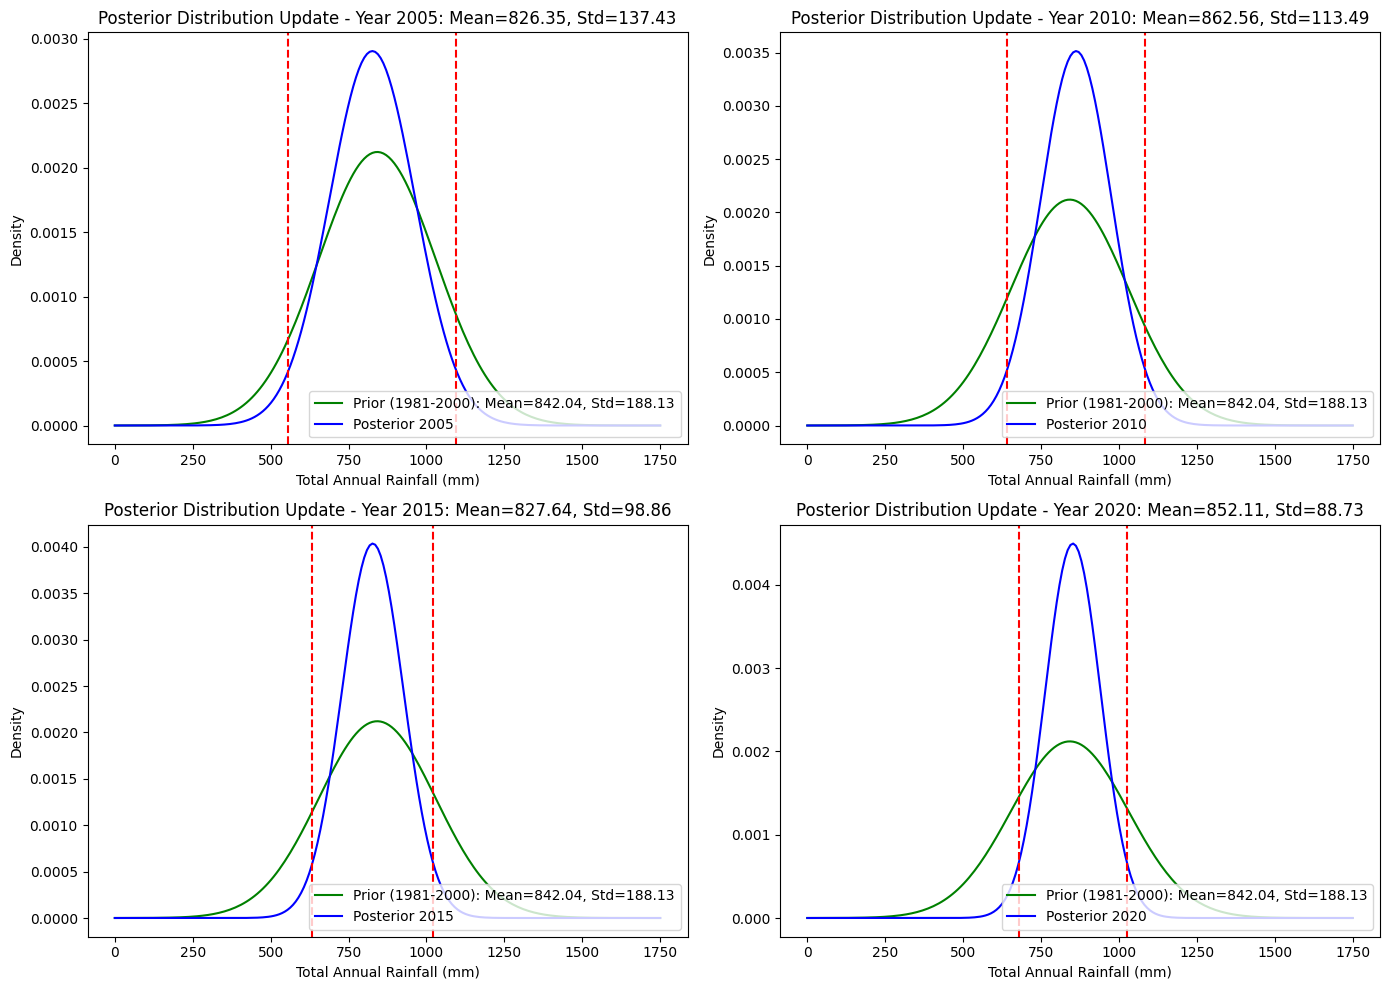

In [155]:
years_to_plot = [2005, 2010, 2015, 2020]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

for i, year in enumerate(years_to_plot):
    posterior_mean = posterior_df.loc[posterior_df['Year'] == year, 'Posterior Mean'].values[0]
    posterior_std = posterior_df.loc[posterior_df['Year'] == year, 'Posterior Standard Deviation'].values[0]
    
    x_prior = np.linspace(0, 1750, 200)
    y_prior = (1 / (np.sqrt(2 * np.pi * prior_variance))) * np.exp(-0.5 * ((x_prior - prior_mean) / prior_std)**2)
    axs[i].plot(x_prior, y_prior, label=f'Prior (1981-2000): Mean={prior_mean:.2f}, Std={prior_standard_deviation:.2f}', color='green', linestyle='-')

    x_posterior = np.linspace(0, 1750, 200)
    y_posterior = (1 / (np.sqrt(2 * np.pi * posterior_std**2))) * np.exp(-0.5 * ((x_posterior - posterior_mean) / posterior_std)**2)
    axs[i].plot(x_posterior, y_posterior, label=f'Posterior {year}', color='blue')

    axs[i].set_title(f"Posterior Distribution Update - Year {year}: Mean={posterior_mean:.2f}, Std={posterior_std:.2f}")
    axs[i].set_xlabel("Total Annual Rainfall (mm)")
    axs[i].set_ylabel("Density")
    axs[i].legend(loc='lower right')

    ci_lower = posterior_mean - 1.96 * posterior_std
    ci_upper = posterior_mean + 1.96 * posterior_std
    axs[i].axvline(ci_lower, color='red', linestyle='--', label='95% Credible Interval')
    axs[i].axvline(ci_upper, color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [156]:
years_to_plot = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
                 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
credible_intervals = []
for year in years_to_plot:
    posterior_mean = posterior_df.loc[posterior_df['Year'] == year, 'Posterior Mean'].values[0]
    posterior_std = posterior_df.loc[posterior_df['Year'] == year, 'Posterior Standard Deviation'].values[0]
    ci_lower = posterior_mean - 1.96 * posterior_std
    ci_upper = posterior_mean + 1.96 * posterior_std
    credible_intervals.append((year, ci_lower.round(2), ci_upper.round(2)))


credible_intervals_df = pd.DataFrame(credible_intervals, columns=['Year', 'Lower Bound of 95% CI', 'Upper Bound of 95% CI'])

credible_intervals_df['Year'] = credible_intervals_df['Year'].astype(int).round(0)



In [157]:
credible_intervals_df.to_csv('posterior.csv', index=False)

In [158]:
# Join the posterior_df and credible_intervals_df
final_df = posterior_df.merge(credible_intervals_df, on='Year')

# Save the final_df as a CSV file
final_df.to_csv('final_posterior.csv', index=False)

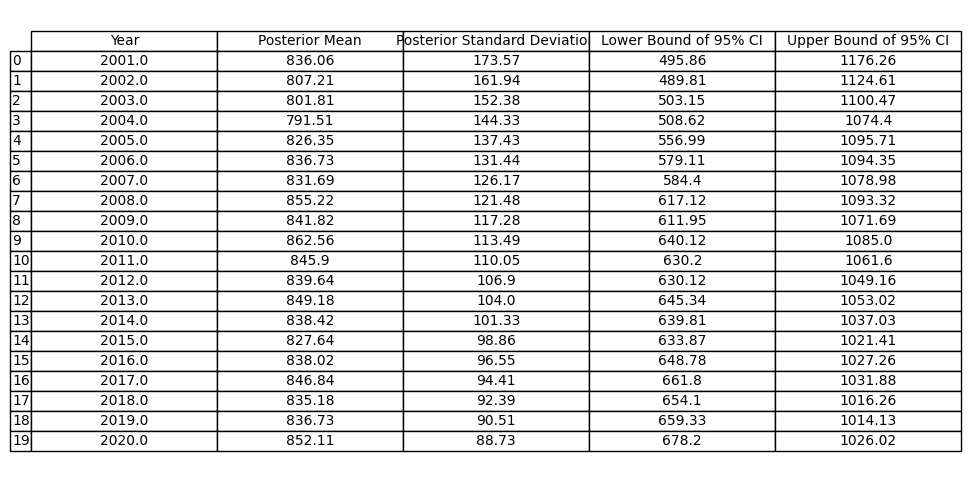

In [159]:
# Display the final_df as an image of a table
final_df['Year'] = final_df['Year'].astype(int).round(0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
tbl = table(ax, final_df, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)

tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)
plt.show()



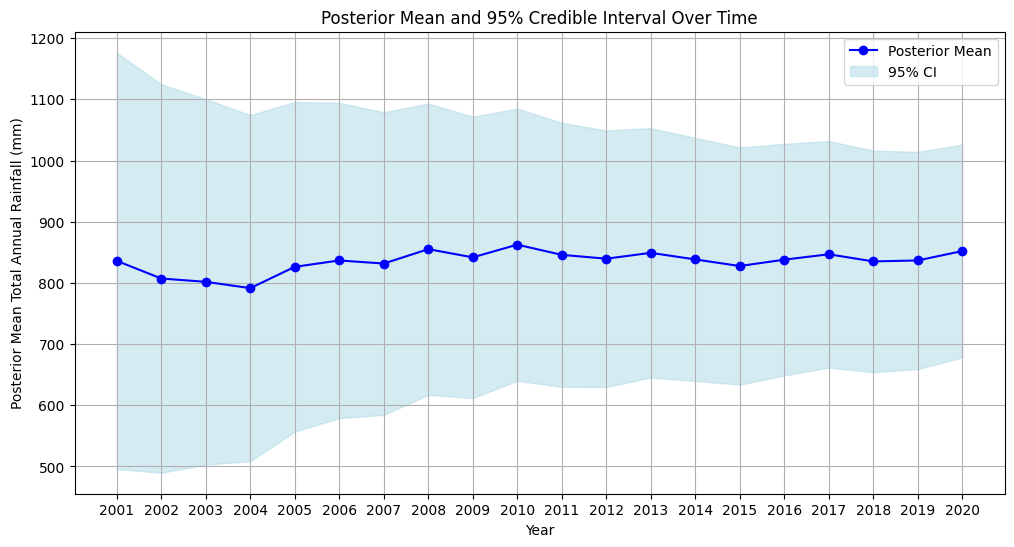

In [160]:
plt.figure(figsize=(12, 6))
plt.plot(final_df['Year'], final_df['Posterior Mean'], marker='o', color='blue', label='Posterior Mean')
plt.fill_between(final_df['Year'], final_df['Lower Bound of 95% CI'], final_df['Upper Bound of 95% CI'], color='lightblue', alpha=0.5, label='95% CI')
plt.title('Posterior Mean and 95% Credible Interval Over Time')
plt.xlabel('Year')
plt.ylabel('Posterior Mean Total Annual Rainfall (mm)')
plt.xticks(final_df['Year'])
plt.legend()
plt.grid(True)
plt.show()